# Procurement and Analysis of Hourly Power Plant Emissions Rates

Power plants across the United States are subject to continuous emissions monitoring requirements to record emissions and submit them to the Environmental Protection Agency (EPA) on a continuous basis.  The EPA’s Air Markets Program Data (AMPD) is a repository for this data which can be publicly accessed at https://ampd.epa.gov/ampd/ or at its ftp site of ftp://newftp.epa.gov/DMDnLoad (Environmental Protection Agency, n.d.).  The data which is stored there includes hourly emissions, fuel throughput, and other pertinent information for each “electric generating unit” (EGU) at each power plant subject to this continuous emissions monitoring requirement.  This information is very useful to state air quality agencies because an EGU’s emissions rate (e.g., lb NOx emitted per MMBtu of fuel combusted) may be calculated for a specific time period, which can often indicate if the unit is using emissions control technologies.  By analyzing historical data, the EGU’s lowest emission rate can be determined, which serves as a benchmark for comparing other emission rates.  Currently, this data must be downloaded manually, typically through the web interface of the AMPD website, and the data analyzed in Excel to determine emissions rates for different pollutants and to compare an EGU’s emissions rates for previous years.  This analysis in Jupyter Notebook will download the dataset for a specific state and a specific number of years (X through current), calculate the lowest daily NOx emissions rates for those units, as well as prepare other statistical information about the units.

## Section 1.0 - Importing Data from Air Markets Program Division

### Section 1.1  - Preparation

To begin, a number of python packages must be imported, to perform the subsequent steps and analysis.

In [1]:
import os, re
import pandas as pd
import geopandas as gpd 
import zipfile
from os import mkdir
from os.path import join, exists, isdir
from ftplib import FTP

The ipywidgets package will allow the use of widgets in the Notebook, such as being able to enter in a text value, and choosing a value from a dropdown list.  The function is a very simple function which is used to return the value of a widget. 

In [2]:
from ipywidgets import widgets 
from ipywidgets import interactive
from IPython.display import display 

def f(x):
    return x

The following widget allows the user to select a specific state.  The chosen state will be used as a filter so as to only search for and download the AMPD data files for that state.  After running the following line, choose a state, and then run the subsequent line.

##### (It is recommended to choose DE to perform the initial analysis, at it has fewer EGUs than most states, resulting in quicker processing times.)

In [3]:
stateList = ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
stateList.sort()
print ('CHOOSE A STATE:')
stAbbr = interactive(f, x=stateList)
display(stAbbr)

CHOOSE A STATE:


interactive(children=(Dropdown(description='x', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE',…

The chosen state is stored in a variable, both in all capital letters and all lowercase letters, depending on how the state abbreviation is needed as a variable.

In [4]:
capState = stAbbr.result
state = capState.lower()

This obtains the current working directory of the Notebook, sets the location of the download folders for FTP files, and defines where to unzip the file.  The code creates the folders if they do not exist.  (Code adapted from Koenig, 2018)

In [5]:
path = os.getcwd() 
downloadFolder = join(path,capState)
unzippedFTPFolder = join(downloadFolder,'unzipped')
outputFolder = join(unzippedFTPFolder,'outputs')
for f in [downloadFolder, unzippedFTPFolder, outputFolder]:
    print (f)
    if not exists(f):
        mkdir(f)

C:\Users\spark\DE
C:\Users\spark\DE\unzipped
C:\Users\spark\DE\unzipped\outputs


The following function will unzip zip files in a specified location.  (Code adapted from Koenig, 2018)

In [6]:
def unzip(zipFile, unzipLocation):
    zip_ref = zipfile.ZipFile(zipFile, 'r')
    zip_ref.extractall(unzipLocation)
    zip_ref.close()

Variables are declared related to the name of the shapefile which will be created.

In [7]:
outputShapefile = outputFolder + '\\minNOx' + state + '.shp'
outputShapefileName = 'minNOx' + state

### Section 1.2  - Accessing and Downloading the FTP Files

The URL of the EPA's FTP site for the AMPD is declared, along with a variable related to the primary directory where the emissions are located on the FTP site.  The folders within that directory (related to each year) are read and added to a list.  (Code adapted from Koenig, 2018)

In [8]:
ftpUrl = "newftp.epa.gov"

ftp = FTP(ftpUrl)
ftp.login()

ftp.cwd("DMDnLoad/emissions/hourly/monthly/")

mainFolder = []
    
ftp.retrlines('NLST', mainFolder.append)

'226 Closing data connection.'

Based upon the folders in the primary directory, the following code cycles through each year of folders, and through the subsequent list of files in each folder.  Within each year there are monthly, zipped, data files for each state.  Only the files for the state previously specified will be downloaded.  Additionally, the code has a filter so that it only downloads the data back through at least 2010.  (This is done in part to ensure the code and program does not crash while analyzing the data.)  As each file is downloaded, the name of each file is downloaded and added to a list.  (Code adapted from Koenig, 2018)

In [9]:
ampd_downloads = []
    
for year in mainFolder:
    if '201' in year:
        path = (str(year))
        ftp.cwd(path)
        filenames = ftp.nlst() 
        for filename in filenames:
            if state in filename:
                local_filename = join(downloadFolder, filename)
                if not exists(local_filename):
                    file = open(local_filename, 'wb')
                    ftp.retrbinary('RETR '+ filename, file.write)
                    file.close()
                    ampd_downloads.append(filename)
        ftp.cwd("../")

ftp.quit()  

'221 Goodbye.'

For the name of each file in the list previously created (which is for each file downloaded), the code iterates through the list and unzips the zip files downloaded to the specified folder.  (Code adapted from Koenig, 2018)

In [10]:
for var in ampd_downloads:
    full_zip_path = join(downloadFolder, var)
    unzip(full_zip_path, unzippedFTPFolder)

## Section 2.0 - Analyzing the AMPD Data

### Section 2.1  - Importing the CSV files and Munging the Data

Each csv file in the specified folder is read, added as a data frame, and appended to a list of all data frames.  A list is used to specify the column type based upon the pre-determined list of column types, as well as to minimize the amount of memory needed for the data frame (Devlin, 2017).  The fifth column (OP_DATE) represents a date, so that column is passed to the parse_dates parameter when reading the csv files.  The list of data frames is then concatenated into an overall data frame.

In [11]:
import glob

ampdFiles = glob.glob(unzippedFTPFolder + "/201?????.csv")
ampdList = []

column_types = {'STATE':'object','FACILITY_NAME':'object','ORISPL_CODE':'object','UNITID':'object','OP_HOUR':'int32','OP_TIME':'float32','GLOAD (MW)':'float32','SLOAD (1000lb/hr)':'float32','SO2_MASS (lbs)':'float32','SO2_MASS_MEASURE_FLG':'category','SO2_RATE (lbs/mmBtu)':'float32','SO2_RATE_MEASURE_FLG':'category','NOX_RATE (lbs/mmBtu)':'float32','NOX_RATE_MEASURE_FLG':'category','NOX_MASS (lbs)':'float32','NOX_MASS_MEASURE_FLG':'category','CO2_MASS (tons)':'float32','CO2_MASS_MEASURE_FLG':'category','CO2_RATE (tons/mmBtu)':'float32','CO2_RATE_MEASURE_FLG':'category','HEAT_INPUT (mmBtu)':'float32','FAC_ID':'object','UNIT_ID':'object'}

for file in ampdFiles:
    df = pd.read_csv(file, header=0, dtype=column_types, parse_dates=[4], low_memory=False)
    ampdList.append(df)

ampdDF = pd.concat(ampdList)
ampdDF.head()

,STATE,FACILITY_NAME,ORISPL_CODE,UNITID,OP_DATE,OP_HOUR,OP_TIME,GLOAD (MW),SLOAD (1000lb/hr),SO2_MASS (lbs),...,NOX_RATE_MEASURE_FLG,NOX_MASS (lbs),NOX_MASS_MEASURE_FLG,CO2_MASS (tons),CO2_MASS_MEASURE_FLG,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),FAC_ID,UNIT_ID
0,DE,Christiana Substation,591,11,2010-01-01,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,378
1,DE,Christiana Substation,591,11,2010-01-01,1,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,378
2,DE,Christiana Substation,591,11,2010-01-01,2,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,378
3,DE,Christiana Substation,591,11,2010-01-01,3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,378
4,DE,Christiana Substation,591,11,2010-01-01,4,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103,378


An info check is run, to see the column names, the column types, and the total number of entries.

In [12]:
ampdDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777320 entries, 0 to 17279
Data columns (total 24 columns):
STATE                    object
FACILITY_NAME            object
ORISPL_CODE              object
UNITID                   object
OP_DATE                  datetime64[ns]
OP_HOUR                  int32
OP_TIME                  float32
GLOAD (MW)               float32
SLOAD (1000lb/hr)        float32
SO2_MASS (lbs)           float32
SO2_MASS_MEASURE_FLG     object
SO2_RATE (lbs/mmBtu)     float32
SO2_RATE_MEASURE_FLG     category
NOX_RATE (lbs/mmBtu)     float32
NOX_RATE_MEASURE_FLG     object
NOX_MASS (lbs)           float32
NOX_MASS_MEASURE_FLG     object
CO2_MASS (tons)          float32
CO2_MASS_MEASURE_FLG     object
CO2_RATE (tons/mmBtu)    float32
CO2_RATE_MEASURE_FLG     category
HEAT_INPUT (mmBtu)       float32
FAC_ID                   object
UNIT_ID                  object
dtypes: category(2), datetime64[ns](1), float32(10), int32(1), object(10)
memory usage: 240.7+ MB


A new "unique" identifier field is created by adding the facility and unit IDs together for each record.

In [13]:
ampdDF['UNIQUE_ID'] = ampdDF['FAC_ID'] + '_' + ampdDF['UNIT_ID']

Another info check is run, to verify that the UNIQUE_ID field is created.

In [14]:
ampdDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777320 entries, 0 to 17279
Data columns (total 25 columns):
STATE                    object
FACILITY_NAME            object
ORISPL_CODE              object
UNITID                   object
OP_DATE                  datetime64[ns]
OP_HOUR                  int32
OP_TIME                  float32
GLOAD (MW)               float32
SLOAD (1000lb/hr)        float32
SO2_MASS (lbs)           float32
SO2_MASS_MEASURE_FLG     object
SO2_RATE (lbs/mmBtu)     float32
SO2_RATE_MEASURE_FLG     category
NOX_RATE (lbs/mmBtu)     float32
NOX_RATE_MEASURE_FLG     object
NOX_MASS (lbs)           float32
NOX_MASS_MEASURE_FLG     object
CO2_MASS (tons)          float32
CO2_MASS_MEASURE_FLG     object
CO2_RATE (tons/mmBtu)    float32
CO2_RATE_MEASURE_FLG     category
HEAT_INPUT (mmBtu)       float32
FAC_ID                   object
UNIT_ID                  object
UNIQUE_ID                object
dtypes: category(2), datetime64[ns](1), float32(10), int32(1), objec

The initial data frame is shuffled to reorganize the columns of data, and renamed as a different data frame.

In [15]:
primeDF = ampdDF[['OP_DATE','OP_HOUR','STATE','UNIQUE_ID','FACILITY_NAME','ORISPL_CODE','UNITID','FAC_ID','UNIT_ID','OP_TIME','GLOAD (MW)','SLOAD (1000lb/hr)','SO2_MASS (lbs)','SO2_MASS_MEASURE_FLG','SO2_RATE (lbs/mmBtu)','SO2_RATE_MEASURE_FLG','NOX_RATE (lbs/mmBtu)','NOX_RATE_MEASURE_FLG','NOX_MASS (lbs)','NOX_MASS_MEASURE_FLG','CO2_MASS (tons)','CO2_MASS_MEASURE_FLG','CO2_RATE (tons/mmBtu)','CO2_RATE_MEASURE_FLG','HEAT_INPUT (mmBtu)']]
primeDF.head()

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,SO2_RATE_MEASURE_FLG,NOX_RATE (lbs/mmBtu),NOX_RATE_MEASURE_FLG,NOX_MASS (lbs),NOX_MASS_MEASURE_FLG,CO2_MASS (tons),CO2_MASS_MEASURE_FLG,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu)
0,2010-01-01,0,DE,103_378,Christiana Substation,591,11,103,378,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-01,1,DE,103_378,Christiana Substation,591,11,103,378,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-01,2,DE,103_378,Christiana Substation,591,11,103,378,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-01,3,DE,103_378,Christiana Substation,591,11,103,378,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-01,4,DE,103_378,Christiana Substation,591,11,103,378,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The unique values for each of the measurement flag columns for the NOx rate, SO2 rate, and CO2 rate columns are determined.  Typically, the measurements are flagged as "Calculated" or "Measured," which represent real data, but sometimes there are missing or incomplete data and historical average data is used instead, which is marked as "Substitute" data.  No "Substitute" flags are desired for the subsequent analyses, so the list of unique values in each "Flag" column will help to decide what data to filter out.

In [16]:
NOXFlags = primeDF['NOX_RATE_MEASURE_FLG'].unique()
SO2Flags = primeDF['SO2_RATE_MEASURE_FLG'].unique()
CO2Flags = primeDF['CO2_RATE_MEASURE_FLG'].unique()
print (NOXFlags, SO2Flags, CO2Flags)

[nan 'Calculated' 'Measured' 'Substitute' 'Measured and Substitute'] [NaN, Calculated]
Categories (1, object): [Calculated] [NaN, Calculated]
Categories (1, object): [Calculated]


Various filters are created and stored as variables to help filter the data frame.  Heat inputs of zero are filtered out to ensure that the EGU is operating, just as the NOx Rate field is filtered for only those values greater than zero.  Since the flag values of "Calculated" and "Measured" are the only ones which are acceptable as real data, the flag for NOx Rate is filtered for these two values.  The data is also filtered for the months from May through September, which represent the "ozone season" during which EGUs are typically subject to more stringent emissions requirements.

In [17]:
heatInputFilter = primeDF['HEAT_INPUT (mmBtu)'] > 0
noxRateFilter = primeDF['NOX_RATE (lbs/mmBtu)'] > 0
noxRateFlagFilterList = ['Measured', 'Calculated']
noxRateFlagFilter = primeDF['NOX_RATE_MEASURE_FLG'].isin(noxRateFlagFilterList)
ozoneSeasonFilter = primeDF['OP_DATE'].dt.month > 4
ozoneSeasonFilter2 = primeDF['OP_DATE'].dt.month < 10

The primary data frame is filtered based upon the filters specified above.  IF data for the entire year is needed (and not just for the ozone season), the second line which is commented out can be run instead of the first line.

In [18]:
nonZeroNOxRateDF = primeDF[heatInputFilter&noxRateFilter&noxRateFlagFilter&ozoneSeasonFilter&ozoneSeasonFilter2]
#nonZeroNOxRateDF = primeDF[heatInputFilter&noxRateFilter&noxRateFlagFilter]

nonZeroNOxRateDF

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,SO2_RATE_MEASURE_FLG,NOX_RATE (lbs/mmBtu),NOX_RATE_MEASURE_FLG,NOX_MASS (lbs),NOX_MASS_MEASURE_FLG,CO2_MASS (tons),CO2_MASS_MEASURE_FLG,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu)
2976,2010-05-01,0,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.093,Measured,41.900002,Measured,46.200001,Measured,0.103,Calculated,450.600006
2977,2010-05-01,1,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.096,Measured,42.599998,Measured,45.599998,Measured,0.103,Calculated,444.100006
2978,2010-05-01,2,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.096,Measured,41.599998,Measured,44.400002,Measured,0.102,Calculated,433.200012
2979,2010-05-01,3,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.099,Measured,43.599998,Measured,45.200001,Measured,0.103,Calculated,440.200012
2980,2010-05-01,4,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.099,Measured,44.500000,Measured,46.099998,Measured,0.103,Calculated,449.200012
2981,2010-05-01,5,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.100,Measured,43.099998,Measured,44.200001,Measured,0.103,Calculated,430.899994
2982,2010-05-01,6,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.095,Measured,43.200001,Measured,46.700001,Measured,0.103,Calculated,454.899994
2983,2010-05-01,7,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.091,Measured,41.200001,Measured,46.400002,Measured,0.103,Calculated,452.399994
2984,2010-05-01,8,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.088,Measured,40.000000,Measured,46.700001,Measured,0.103,Calculated,454.799988
2985,2010-05-01,9,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Calculated,0.089,Measured,40.599998,Measured,46.799999,Measured,0.103,Calculated,456.399994


Four new columns are created which include the average NOx rate, the average SO2 rate, the average CO2 rate, each as daily averages, and the number of records which are included in the averages for each EGU.

In [ ]:
noxRateAvg = nonZeroNOxRateDF.groupby(['STATE','FACILITY_NAME','ORISPL_CODE','UNITID','FAC_ID','UNIT_ID','UNIQUE_ID','OP_DATE'])['NOX_RATE (lbs/mmBtu)'].transform(lambda x : x.mean())
so2RateAvg = nonZeroNOxRateDF.groupby(['STATE','FACILITY_NAME','ORISPL_CODE','UNITID','FAC_ID','UNIT_ID','UNIQUE_ID','OP_DATE'])['SO2_RATE (lbs/mmBtu)'].transform(lambda x : x.mean())
co2RateAvg = nonZeroNOxRateDF.groupby(['STATE','FACILITY_NAME','ORISPL_CODE','UNITID','FAC_ID','UNIT_ID','UNIQUE_ID','OP_DATE'])['CO2_RATE (tons/mmBtu)'].transform(lambda x : x.mean())

dayCount = nonZeroNOxRateDF.groupby(['STATE','FACILITY_NAME','ORISPL_CODE','UNITID','FAC_ID','UNIT_ID','UNIQUE_ID','OP_DATE'])['NOX_RATE (lbs/mmBtu)'].transform(lambda x : x.count())

nonZeroNOxRateDF['DailyNOxAvg'] = noxRateAvg
nonZeroNOxRateDF['DailySO2Avg'] = so2RateAvg
nonZeroNOxRateDF['DailyCO2Avg'] = co2RateAvg

nonZeroNOxRateDF['day_count'] = dayCount


Two more columns are added to specify the month and the year, based upon the datetime field of OP_DATE.  The creation of the two new columns is done after filtering to minimize processing time.

In [ ]:
nonZeroNOxRateDF['YEAR'] = pd.DatetimeIndex(nonZeroNOxRateDF['OP_DATE']).year
nonZeroNOxRateDF['MONTH'] = pd.DatetimeIndex(nonZeroNOxRateDF['OP_DATE']).month

Another info check, to verify that the 6 new columns were created.

In [21]:
nonZeroNOxRateDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272332 entries, 2976 to 17279
Data columns (total 31 columns):
OP_DATE                  272332 non-null datetime64[ns]
OP_HOUR                  272332 non-null int32
STATE                    272332 non-null object
UNIQUE_ID                272332 non-null object
FACILITY_NAME            272332 non-null object
ORISPL_CODE              272332 non-null object
UNITID                   272332 non-null object
FAC_ID                   272332 non-null object
UNIT_ID                  272332 non-null object
OP_TIME                  272332 non-null float32
GLOAD (MW)               237108 non-null float32
SLOAD (1000lb/hr)        35224 non-null float32
SO2_MASS (lbs)           241368 non-null float32
SO2_MASS_MEASURE_FLG     241368 non-null object
SO2_RATE (lbs/mmBtu)     241368 non-null float32
SO2_RATE_MEASURE_FLG     241368 non-null category
NOX_RATE (lbs/mmBtu)     272332 non-null float32
NOX_RATE_MEASURE_FLG     272332 non-null object
NOX_MASS 

Here is how the data in the data frame looks now, which will be the primary data frame for subsequent analyses and queries.

In [22]:
nonZeroNOxRateDF

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,CO2_MASS_MEASURE_FLG,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),DailyNOxAvg,DailySO2Avg,DailyCO2Avg,day_count,YEAR,MONTH
2976,2010-05-01,0,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,450.600006,0.091500,0.348083,0.101917,24.0,2010,5
2977,2010-05-01,1,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,444.100006,0.091500,0.348083,0.101917,24.0,2010,5
2978,2010-05-01,2,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.102,Calculated,433.200012,0.091500,0.348083,0.101917,24.0,2010,5
2979,2010-05-01,3,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,440.200012,0.091500,0.348083,0.101917,24.0,2010,5
2980,2010-05-01,4,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,449.200012,0.091500,0.348083,0.101917,24.0,2010,5
2981,2010-05-01,5,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,430.899994,0.091500,0.348083,0.101917,24.0,2010,5
2982,2010-05-01,6,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,454.899994,0.091500,0.348083,0.101917,24.0,2010,5
2983,2010-05-01,7,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,452.399994,0.091500,0.348083,0.101917,24.0,2010,5
2984,2010-05-01,8,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,454.799988,0.091500,0.348083,0.101917,24.0,2010,5
2985,2010-05-01,9,DE,105_382,Edge Moor,593,3,105,382,1.0,...,Measured,0.103,Calculated,456.399994,0.091500,0.348083,0.101917,24.0,2010,5


### Section 2.2  - Determining the Lowest and Highest Daily NOx Rates by EGU

Only the flag field for the NOx rate was filtered for "Calculated" or "Measured" data, since the NOx rate is the most important field in the analysis.  However, the SO2 rate and CO2 rate are useful and will be helpful at a later point in the analysis.  If the SO2 and CO2 rate flag fields were filtered the same way, they could potentially remove some records of good data for determining the daily NOx rate average.  Thus, a check for substitute data in either the SO2 or CO2 rate flag columns is implemented, and a new field is added based upon this Boolean check.  Thus, this field can be filtered for, to determine IF any of the days in the analysis data include SO2 rate or CO2 rate which includes substitute data.

In [ ]:
so2Check = nonZeroNOxRateDF['SO2_RATE (lbs/mmBtu)'].isin(['Substitute'])
co2Check = nonZeroNOxRateDF['CO2_RATE (tons/mmBtu)'].isin(['Substitute'])
subCheck = list(so2Check | co2Check)
nonZeroNOxRateDF['SO2_or_CO2_Sub'] = subCheck

The data frame is sorted by the columns of YEAR, UNIQUE_ID and DailyNOxAvg (each ascending) in order to perform the next step.

In [24]:
dfSorted = nonZeroNOxRateDF.sort_values(by=['YEAR','UNIQUE_ID','DailyNOxAvg'])
dfSorted

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),DailyNOxAvg,DailySO2Avg,DailyCO2Avg,day_count,YEAR,MONTH,SO2_or_CO2_Sub
0,2010-08-01,0,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,252.199997,0.20000,0.5000,0.081000,4.0,2010,8,False
1,2010-08-01,1,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,269.000000,0.20000,0.5000,0.081000,4.0,2010,8,False
2,2010-08-01,2,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,269.000000,0.20000,0.5000,0.081000,4.0,2010,8,False
3,2010-08-01,3,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,269.000000,0.20000,0.5000,0.081000,4.0,2010,8,False
0,2010-09-01,0,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,269.000000,0.20000,0.5000,0.081000,2.0,2010,9,False
1,2010-09-01,1,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,285.799988,0.20000,0.5000,0.081000,2.0,2010,9,False
0,2010-07-01,0,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,235.399994,0.20000,0.5000,0.081000,14.0,2010,7,False
1,2010-07-01,1,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,235.399994,0.20000,0.5000,0.081000,14.0,2010,7,False
2,2010-07-01,2,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,252.199997,0.20000,0.5000,0.081000,14.0,2010,7,False
3,2010-07-01,3,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,252.199997,0.20000,0.5000,0.081000,14.0,2010,7,False


With the data frame sorted by year, the unique ID, and the daily average (in ascending order), the first daily average for each year and unique ID represents the lowest daily average for each unit at each facility for each year.  The groupby function extracts these values into a new data frame.

In [25]:
minNOxRateDF = dfSorted.groupby(['YEAR','UNIQUE_ID']).head(1)
minNOxRateDF

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),DailyNOxAvg,DailySO2Avg,DailyCO2Avg,day_count,YEAR,MONTH,SO2_or_CO2_Sub
0,2010-08-01,0,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,252.199997,0.200000,0.500000,0.081000,4.0,2010,8,False
744,2010-08-01,0,DE,103_379,Christiana Substation,591,14,103,379,1.00,...,0.081,Calculated,254.399994,0.220000,0.500000,0.081000,5.0,2010,8,False
1488,2010-08-01,0,DE,104_380,Delaware City,592,10,104,380,1.00,...,NaN,NaN,112.199997,0.220000,NaN,NaN,12.0,2010,8,False
2232,2010-08-01,0,DE,105_381,Edge Moor,593,10,105,381,1.00,...,NaN,NaN,130.800003,0.250000,NaN,NaN,4.0,2010,8,False
3048,2010-07-04,0,DE,105_382,Edge Moor,593,3,105,382,1.00,...,0.059,Calculated,489.000000,0.029000,0.002833,0.059000,24.0,2010,7,False
4077,2010-06-20,21,DE,105_383,Edge Moor,593,4,105,383,1.00,...,0.059,Calculated,146.500000,0.003000,0.001000,0.059000,1.0,2010,6,False
4555,2010-08-04,19,DE,105_384,Edge Moor,593,5,105,384,0.75,...,0.060,Calculated,107.025002,0.018400,0.007400,0.059200,5.0,2010,8,False
5348,2010-06-13,20,DE,106_385,Indian River,594,1,106,385,1.00,...,0.103,Calculated,39.700001,0.007250,0.136500,0.102750,4.0,2010,6,False
6352,2010-06-25,16,DE,106_386,Indian River,594,10,106,386,1.00,...,NaN,NaN,55.400002,0.612000,NaN,NaN,1.0,2010,6,False
7696,2010-09-21,16,DE,106_388,Indian River,594,3,106,388,1.00,...,0.104,Calculated,31.700001,0.028571,0.145857,0.102571,7.0,2010,9,False


Extraneous columns are removed as a new data frame is named.

In [26]:
minNOxRatePrimeDF = minNOxRateDF[['OP_DATE','YEAR','MONTH','STATE','UNIQUE_ID','FACILITY_NAME','ORISPL_CODE','UNITID','DailyNOxAvg','DailySO2Avg','DailyCO2Avg','SO2_or_CO2_Sub']].copy()
minNOxRatePrimeDF

,OP_DATE,YEAR,MONTH,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,DailyNOxAvg,DailySO2Avg,DailyCO2Avg,SO2_or_CO2_Sub
0,2010-08-01,2010,8,DE,103_378,Christiana Substation,591,11,0.200000,0.500000,0.081000,False
744,2010-08-01,2010,8,DE,103_379,Christiana Substation,591,14,0.220000,0.500000,0.081000,False
1488,2010-08-01,2010,8,DE,104_380,Delaware City,592,10,0.220000,NaN,NaN,False
2232,2010-08-01,2010,8,DE,105_381,Edge Moor,593,10,0.250000,NaN,NaN,False
3048,2010-07-04,2010,7,DE,105_382,Edge Moor,593,3,0.029000,0.002833,0.059000,False
4077,2010-06-20,2010,6,DE,105_383,Edge Moor,593,4,0.003000,0.001000,0.059000,False
4555,2010-08-04,2010,8,DE,105_384,Edge Moor,593,5,0.018400,0.007400,0.059200,False
5348,2010-06-13,2010,6,DE,106_385,Indian River,594,1,0.007250,0.136500,0.102750,False
6352,2010-06-25,2010,6,DE,106_386,Indian River,594,10,0.612000,NaN,NaN,False
7696,2010-09-21,2010,9,DE,106_388,Indian River,594,3,0.028571,0.145857,0.102571,False


Although the OP_DATE field represents a datetime object, it will also be useful to have the date listed in a text field.  The following line adds such a new text field to the data frame.

In [27]:
minNOxRatePrimeDF['Date_String'] = minNOxRatePrimeDF['OP_DATE'].dt.strftime('%Y-%m-%d')

Another info check is run, to view the columns of data in the data frame which includes the lowest daily NOx rates, by EGU, for the specified state, over the time period being analyzed.

In [28]:
minNOxRatePrimeDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 13335
Data columns (total 13 columns):
OP_DATE           221 non-null datetime64[ns]
YEAR              221 non-null int64
MONTH             221 non-null int64
STATE             221 non-null object
UNIQUE_ID         221 non-null object
FACILITY_NAME     221 non-null object
ORISPL_CODE       221 non-null object
UNITID            221 non-null object
DailyNOxAvg       221 non-null float32
DailySO2Avg       158 non-null float32
DailyCO2Avg       174 non-null float32
SO2_or_CO2_Sub    221 non-null bool
Date_String       221 non-null object
dtypes: bool(1), datetime64[ns](1), float32(3), int64(2), object(6)
memory usage: 20.1+ KB


The following lines perform the same set of steps to determine the highest daily NOx rates, by EGU, for the specified state, over the time period being analyzed.

In [29]:
maxNOxRateDF = dfSorted.groupby(['YEAR','UNIQUE_ID']).tail(1)
maxNOxRateDF

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),DailyNOxAvg,DailySO2Avg,DailyCO2Avg,day_count,YEAR,MONTH,SO2_or_CO2_Sub
13,2010-07-01,13,DE,103_378,Christiana Substation,591,11,103,378,1.00,...,0.081,Calculated,235.399994,0.200000,0.500000,0.081000,14.0,2010,7,False
726,2010-09-01,6,DE,103_379,Christiana Substation,591,14,103,379,1.00,...,0.081,Calculated,270.299988,0.220000,0.500000,0.081000,7.0,2010,9,False
1499,2010-08-01,11,DE,104_380,Delaware City,592,10,104,380,1.00,...,NaN,NaN,112.199997,0.220000,NaN,NaN,12.0,2010,8,False
2239,2010-07-01,7,DE,105_381,Edge Moor,593,10,105,381,1.00,...,NaN,NaN,49.099998,0.251000,NaN,NaN,8.0,2010,7,False
3215,2010-06-14,23,DE,105_382,Edge Moor,593,3,105,382,1.00,...,0.103,Calculated,949.900024,0.134458,0.351833,0.103000,24.0,2010,6,False
3911,2010-06-13,23,DE,105_383,Edge Moor,593,4,105,383,1.00,...,0.103,Calculated,1094.699951,0.137875,0.353583,0.103000,24.0,2010,6,False
4895,2010-07-18,23,DE,105_384,Edge Moor,593,5,105,384,1.00,...,0.059,Calculated,2179.699951,0.126800,0.286533,0.069200,15.0,2010,7,False
5783,2010-07-24,23,DE,106_385,Indian River,594,1,106,385,1.00,...,0.103,Calculated,770.400024,0.275583,1.413083,0.103000,24.0,2010,7,False
6117,2010-07-07,21,DE,106_386,Indian River,594,10,106,386,1.00,...,NaN,NaN,262.299988,0.612000,NaN,NaN,8.0,2010,7,False
7679,2010-08-10,23,DE,106_388,Indian River,594,3,106,388,1.00,...,0.103,Calculated,1462.400024,0.399083,1.407542,0.103000,24.0,2010,8,False


In [30]:
maxNOxRatePrimeDF = maxNOxRateDF[['OP_DATE','YEAR','MONTH','STATE','UNIQUE_ID','FACILITY_NAME','ORISPL_CODE','UNITID','DailyNOxAvg','DailySO2Avg','DailyCO2Avg','SO2_or_CO2_Sub']].copy()
maxNOxRatePrimeDF.head()

,OP_DATE,YEAR,MONTH,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,DailyNOxAvg,DailySO2Avg,DailyCO2Avg,SO2_or_CO2_Sub
13,2010-07-01,2010,7,DE,103_378,Christiana Substation,591,11,0.200000,0.500000,0.081,False
726,2010-09-01,2010,9,DE,103_379,Christiana Substation,591,14,0.220000,0.500000,0.081,False
1499,2010-08-01,2010,8,DE,104_380,Delaware City,592,10,0.220000,NaN,NaN,False
2239,2010-07-01,2010,7,DE,105_381,Edge Moor,593,10,0.251000,NaN,NaN,False
3215,2010-06-14,2010,6,DE,105_382,Edge Moor,593,3,0.134458,0.351833,0.103,False


In [31]:
maxNOxRatePrimeDF['Date_String'] = maxNOxRatePrimeDF['OP_DATE'].dt.strftime('%Y-%m-%d')

In [32]:
maxNOxRatePrimeDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 13 to 12806
Data columns (total 13 columns):
OP_DATE           221 non-null datetime64[ns]
YEAR              221 non-null int64
MONTH             221 non-null int64
STATE             221 non-null object
UNIQUE_ID         221 non-null object
FACILITY_NAME     221 non-null object
ORISPL_CODE       221 non-null object
UNITID            221 non-null object
DailyNOxAvg       221 non-null float32
DailySO2Avg       158 non-null float32
DailyCO2Avg       174 non-null float32
SO2_or_CO2_Sub    221 non-null bool
Date_String       221 non-null object
dtypes: bool(1), datetime64[ns](1), float32(3), int64(2), object(6)
memory usage: 20.1+ KB


### Section 2.3  - Exporting the Resulting Data Frames

With the creation of the data frames to represent the lowest and highest daily NOx rate averages, each data frame is exported to a csv file in the specified output folder.

In [33]:
minOutputCSV = outputFolder + '\\minNOxOutput' + capState + '.csv'
if os.path.exists(minOutputCSV):
    os.remove(minOutputCSV)
minNOxRatePrimeDF.to_csv(minOutputCSV)
maxOutputCSV = outputFolder + '\\maxNOxOutput' + capState + '.csv'
if os.path.exists(maxOutputCSV):
    os.remove(maxOutputCSV)
maxNOxRatePrimeDF.to_csv(maxOutputCSV)

## Section 3.0 - Visualizing the Data

### Section 3.1  - Obtaining Coordinates

The AMPD data downloaded by FTP does not inlude the coordinates associated with each facility or EGU.  Thus, in order to map the data, an external source of coordinates for each facility must be obtained.  A report was run from the AMPD website which included the coordinates for all facilities (Environmental Protection Agency, n.d.).  Extraneous columns were removed from the file, which was then saved as a csv file with the latitude and longitude coordinates for each facility, based upon their ORIS (Office of Regulatory Information Systems) identification number.  This csv file can be downloaded at:  https://psu.box.com/s/2uriskgz4dwpkuryofob1lm44m8d7kd2 

##### It is recommended that the facility coordinates csv file be downloaded to the user's "Downloads" folder, for simpliticy.

Once downloaded, and the following line of code is run, the directory of the folder should be entered in the text field which pops up.  Press enter after entering the directory of the folder and move on to the next line of code.

In [34]:
outputText = widgets.Text(placeholder='C:\Folder\subfolder')
display(outputText)

def handle_submit(sender):
        print(outputText.value)
        return(outputText.value)

outputText.on_submit(handle_submit)

Text(value='', placeholder='C:\\Folder\\subfolder')

C:\FTP_temp\unzipped\outputs


The directory entered is stored as a variable and used to access and read in the facility coordinates csv file into a new data frame.  The index of the data frame is set based upon the field for ORIS identification number.

In [35]:
fileFolder = str(outputText.value)
coordsCSV = fileFolder + '\\facility_coords.csv'

column_types = {'ORIS':'object','State':'object','Facility Name':'object','Latitude':'float64','Longitude':'float64'}

facilitiesDF = pd.read_csv(coordsCSV, header=0, dtype=column_types, encoding='utf-8')
coordsDF = facilitiesDF.set_index('ORIS')
coordsDF.head()

,State,Facility Name,Latitude,Longitude
ORIS,,,,
56018,AL,AMEA Sylacauga Plant,33.1661,-86.2825
880041,AL,Ascend (Decatur Plant),34.6339,-87.0244
3,AL,Barry,31.0069,-88.0103
55409,AL,Calhoun Energy Center,33.5883,-85.9731
56,AL,Charles R Lowman,31.4858,-87.9106


An info check is run, to see the column names and column types of the facility coordinates data.

In [36]:
coordsDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1789 entries, 56018 to 60357
Data columns (total 4 columns):
State            1789 non-null object
Facility Name    1789 non-null object
Latitude         1789 non-null float64
Longitude        1789 non-null float64
dtypes: float64(2), object(2)
memory usage: 69.9+ KB


### Section 3.2  - Creating a Shapefile of the Lowest Daily NOx Rate Average by EGU

The modules associated with GDAL/OGR are imported to assist with the creation of the shapefile.

In [37]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

To begin the process of creating the shapefile for lowest daily NOx rate average for each EGU, a driver object is obtained first along with declaring a spatial refernce object for the WGS84 coordinate system. The code below checks to see if an existing shapefile in the output folder exists with the same name of the output shapefile which was declared above, and if there is, the existing shapefile is deleted.

In [38]:
drv = ogr.GetDriverByName('ESRI Shapefile')
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)  
if os.path.exists(outputShapefile):
    drv.DeleteDataSource(outputShapefile)

In the following code a new layer is created for the new shapefile to be created. Multiple new fields are set up to match the fields in the data frame being used to create the shapefile, based on whether they contain text, integers, or decimals.

In [39]:
outFile = drv.CreateDataSource(outputShapefile)
outLayer = outFile.CreateLayer(outputShapefileName, geom_type=ogr.wkbPoint, srs=sr)
featureDefn = outLayer.GetLayerDefn()

field_Date = ogr.FieldDefn("Date", ogr.OFTString)
field_Date.SetWidth(10)
outLayer.CreateField(field_Date)
outLayer.CreateField(ogr.FieldDefn("Year", ogr.OFTInteger))
outLayer.CreateField(ogr.FieldDefn("Month", ogr.OFTInteger))
field_State = ogr.FieldDefn("State", ogr.OFTString)
field_State.SetWidth(2)
outLayer.CreateField(field_State)
field_UniqueID = ogr.FieldDefn("UniqueID", ogr.OFTString)
field_UniqueID.SetWidth(10)
outLayer.CreateField(field_UniqueID)
field_FacName = ogr.FieldDefn("FacName", ogr.OFTString)
field_FacName.SetWidth(100)
outLayer.CreateField(field_FacName)
field_ORIS = ogr.FieldDefn("ORIS", ogr.OFTString)
field_ORIS.SetWidth(20)
outLayer.CreateField(field_ORIS)
field_UnitID = ogr.FieldDefn("UnitID", ogr.OFTString)
field_UnitID.SetWidth(5)
outLayer.CreateField(field_UnitID)
outLayer.CreateField(ogr.FieldDefn("MinNOxAvg", ogr.OFTReal))
outLayer.CreateField(ogr.FieldDefn("SO2Avg", ogr.OFTReal))
outLayer.CreateField(ogr.FieldDefn("CO2Avg", ogr.OFTReal))
field_SubFlag = ogr.FieldDefn("SubFlag", ogr.OFTString)
field_SubFlag.SetWidth(10)
outLayer.CreateField(field_SubFlag)

0

The data from the data frame can now be added to the shapefile. The code below reads each line of the data frame, matches the column of each row of data to the list of fields declared in the layer, and adds them along with a point as the geometry for EGU/record of the data frame.

One other note, two blank lists are created in the start of the following line, and are populated with the list of x (longitude) and y (latitude) values from each EGU. These lists will be utilized below.

In [40]:
XList = []
YList = []

for row in minNOxRatePrimeDF.itertuples(index=False):
    outFeature = ogr.Feature(featureDefn)
    outFeature.SetField("Date", row.Date_String)
    outFeature.SetField("Year", row.YEAR)
    outFeature.SetField("Month", row.MONTH)
    outFeature.SetField("State", row.STATE)
    outFeature.SetField("UniqueID", row.UNIQUE_ID)
    outFeature.SetField("FacName", row.FACILITY_NAME)
    outFeature.SetField("ORIS", row.ORISPL_CODE)
    outFeature.SetField("UnitID", row.UNITID)
    outFeature.SetField("MinNOxAvg", row.DailyNOxAvg)
    outFeature.SetField("SO2Avg", row.DailySO2Avg)
    outFeature.SetField("CO2Avg", row.DailyCO2Avg)
    outFeature.SetField("SubFlag", row.SO2_or_CO2_Sub)
    points = ogr.Geometry(ogr.wkbPoint)
    orisCode = row.ORISPL_CODE
    GX = coordsDF.Longitude[orisCode]
    GY = coordsDF.Latitude[orisCode]
    XList.append(GX)
    YList.append(GY)
    points.AddPoint(GX,GY)
    outFeature.SetGeometry(points)
    outLayer.CreateFeature(outFeature)
    outFeature = None
outFile = None

### Section 3.3  - Uploading the Shapefile of the User's ArcGIS Online Account and Presenting The Data in a Map Widget

The code below is borrowed from the Lesson 3 walkthrough, and zips all files of the shapefile (Quinn, Detwiler, Hardisty, & O’Brien, 1999-2018).  The code creates a new function which looks for all files (regardless of file extension) with the same name as the shapefile previously created, and creates a zipfile of all those files.

In [41]:
import zipfile

def zipShapefile(name):
    compiledRE = re.compile(name+'(?!.zip)\....$')
    with zipfile.ZipFile( os.path.join(outputFolder, name + '.zip'), 'w', zipfile.ZIP_DEFLATED) as zf:  
        for file in os.listdir(outputFolder):                                         
            if compiledRE.match(file):                                               
                zf.write(os.path.join(outputFolder,file),file,zipfile.ZIP_DEFLATED)             
                
zipShapefile(os.path.splitext(outputShapefileName)[0] )

The user's username and password for their ArcGIS Online account is needed, as they will be needed to publish the final shapefile. The getpass module and its functions are used so that the user can enter their username and password without them being hardcoded into the script.  Please fill in your username and password in boxes which pop up after running the following line.

In [42]:
import getpass
usernameAGOL = getpass.getpass()
passwordAGOL = getpass.getpass()

········
········


To begin the process of uploading the shapefile to ArcGIS Online and presenting the shapefilein a map widget, the arcgis.gis module must first be imported and a GIS object created using the ESRI website and the user's ArcGIS Online username and password.

*If an error occurs such as "Unable to generate token. Invalid username or password.",  Reenter your ArcGIS Online username and password above.

In [43]:
from arcgis.gis import GIS
gis = GIS('https://www.arcgis.com', usernameAGOL, passwordAGOL)

Prior to uploading the zipfile with the shapefile to the user's ArcGIS Online account, the following line checks to see if there is already a feature layer or shapefile in the user's account with the same name as the shapefile.  If such files exist, the publishing of the shapefile into the user's account will fail.  If there is not, the user can proceed with the rest of these instructions.  By checking to see if there is a feature layer or shapefile already in the user's account, the code deletes those files if they exist, so that the rest of the instructions can be performed.

In [44]:
titleQuery = 'title:' + str(outputShapefileName)
try:
    existingFile = gis.content.search(titleQuery, item_type = 'Shapefile')[0]
    print ('A shapefile with that name already exists in your AGOL account.')
    existingFile_id = existingFile.id
    deleteExistingFile = gis.content.get(existingFile_id)
    deleteExistingFile.delete()
    print ('The existing shapefile in your AGOL account has been deleted.')
except:
    print('No shapefile with that name exists in your AGOL account.')
try:
    existingFile = gis.content.search(titleQuery, item_type = 'Feature Layer')[0]
    print ('A feature layer with that name already exists in your AGOL account.')
    existingFile_id = existingFile.id
    deleteExistingFile = gis.content.get(existingFile_id)
    deleteExistingFile.delete()
    print ('The existing feature layer in your AGOL account has been deleted.')
except:
    print('No feature layer with that name exists in your AGOL account.')

A shapefile with that name already exists in your AGOL account.
The existing shapefile in your AGOL account has been deleted.
A feature layer with that name already exists in your AGOL account.
The existing feature layer in your AGOL account has been deleted.


The zipped shapefile is uploaded to the user's ArcGIS Online account and published for use in a map widget.

In [45]:
zippedSHP = outputFolder + '\\' + outputShapefileName + '.zip'
minNOxSHP = gis.content.add({}, zippedSHP)
minNOxSHPpub = minNOxSHP.publish()

The previous lists of all the latitude and longitude coordinates are utilized in the following code to find the minimum and maximum of each. The distance between the minimum and maximum of the longitudes and latitudes are determined, which represents the center of all EGUs of the shapefile. This "center value" is used in the final step, to center the map which is created.

In [46]:
maxX = max(XList)
minX = min(XList)
maxY = max(YList)
minY = min(YList)
centerX = minX - (minX - maxX)/2
centerY = maxY - (maxY - minY)/2
print (centerX, centerY)

-75.4339 39.16465


In this final step, a map widget is created which adds the shapefile to the map, and is centered on the shapefile data which is added, and appropriately zoomed in to the data, as well.

In [47]:
minNOxRatePAMap = gis.map()
minNOxRatePAMap.add_layer(minNOxSHPpub, {})
minNOxRatePAMap.center = [centerY, centerX]
minNOxRatePAMap.zoom = 6
minNOxRatePAMap

MapView(layout=Layout(height='400px', width='100%'), zoom=6.0)

## Section 4.0 - Analyzing Data in R

### Section 4.1  - Analyzing the Lowest and Highest Daily NOx Rate Averages by EGU

To begin the analysis of the lowest daily NOx rate averages by EGU, the following "magic command" must be run in order to prepare Jupyter Notebook to interface with R.

In [48]:
%load_ext rpy2.ipython

To perform any analysis of our existing data, certain variables and data frames must be transfered over to R.

In [ ]:
%R -i minNOxRatePrimeDF
%R -i maxNOxRatePrimeDF
%R -i capState

Below are box plots, representing the lowest and highest daily NOx rate averages of the EGUs in the specified state, by year.  The dash in the middle of the box represents the median of the data, while the box in the middle represents the upper and lower quartile of the data (i.e, 25% of the data is greater than or less than these values).  The "whiskers" as the top and bottom of the box represent mininum and maximum values of the data, excluding any outliers.

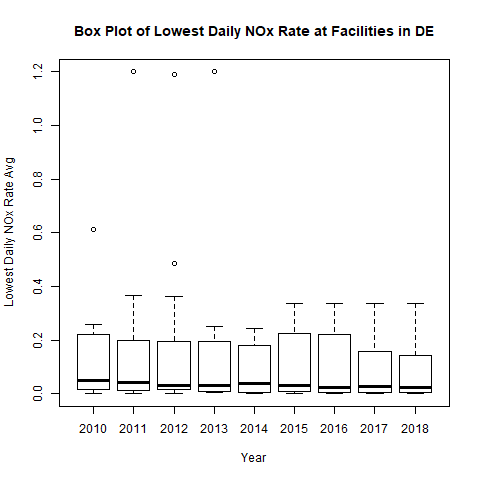

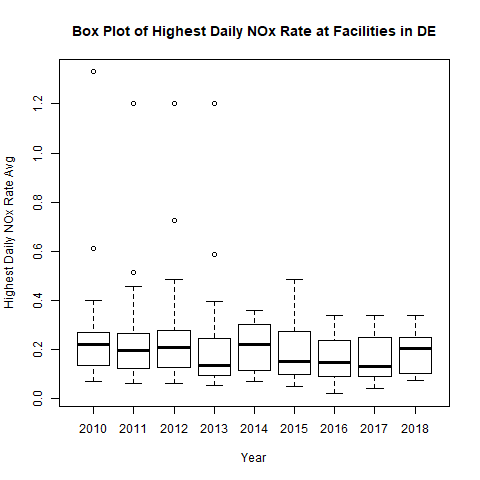

R object with classes: ('list',) mapped to:
<ListVector - Python:0x000002180C370A08 / R:0x0000021831C66F60>
[Matrix, Float..., Matrix, Float..., Float..., StrVe...]
  stats: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000002180C27BE08 / R:0x00000218314CC930>
[0.069667, 0.134458, 0.220000, 0.270000, ..., 0.099637, 0.204958, 0.248750, 0.336000]
  n: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000002183350FC08 / R:0x0000021831C678B0>
[26.000000, 24.000000, 25.000000, 25.000000, ..., 25.000000, 24.000000, 24.000000, 24.000000]
  conf: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000002180C2739C8 / R:0x0000021831CAD858>
[0.178001, 0.261999, 0.148587, 0.241122, ..., 0.080627, 0.182973, 0.156867, 0.253050]
  out: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000002183375BFC8 / R:0x0000021831C67A00>
[0.612000, 1.330458, 1.200000, 1.200000, ..., 1.200500, 0.726000, 1.203000, 0.585000]
  group: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000002183375BE88 / R:0x0000021831C67958>
[1.000000, 1.000000, 2.000000, 2.000000, ..., 3.000000, 3.000000, 4.000000, 4.000000]
  names: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000021833750F48 / R:0x00000218312DD068>
['2010', '2011', '2012', '2013', ..., '2015', '2016', '2017', '2018']

In [50]:
%R boxplot(DailyNOxAvg~YEAR, data=minNOxRatePrimeDF, xlab='Year',ylab='Lowest Daily NOx Rate Avg', main=paste('Box Plot of Lowest Daily NOx Rate at Facilities in', capState, sep=" "))
%R boxplot(DailyNOxAvg~YEAR, data=maxNOxRatePrimeDF, xlab='Year',ylab='Highest Daily NOx Rate Avg', main=paste('Box Plot of Highest Daily NOx Rate at Facilities in', capState, sep=" "))

### Section 4.2  - Analyzing the Data for a Specific EGU

The box plots above for the lowest and highest daily NOx rate average are useful in showing how the daily NOx rate averages compare in a given state over time.  Next, the daily NOx rate averages will be analyzed for a specific EGU at a specific facility, over the time period being considered.

The code below creates a list of all unique facilities located within the state being considered.

In [53]:
facilitiesList = list(nonZeroNOxRateDF['FACILITY_NAME'].unique())
facilitiesList.sort()

After running the following line, a dropdown will appear which will allow the user to select a specific facility.  Once selected, move on to the next line.  The same "simple" function is declared again so as to be able to easily return the chosen facility as a variable.

##### It is recommended that the Indian River facility be chosen, as an initial example, as this facility is Delaware's last remaining power plant which utilizes coal.)

In [55]:
def f(x):
    return x

print ('CHOOSE A FACILITY:')
site = interactive(f, x=facilitiesList)
display(site)

CHOOSE A FACILITY:


interactive(children=(Dropdown(description='x', options=('Christiana Substation', 'Delaware City', 'Delaware C…

The facility chosen is stored in a variable which is used to filter the list of EGUs located at the facility chosen, which are made into a list.

In [58]:
unitFilter = nonZeroNOxRateDF.loc[nonZeroNOxRateDF['FACILITY_NAME'] == site.result]
unitList = list(unitFilter['UNITID'].unique())
unitList.sort()

After running the following line a code, a dropdown will appear which will allow the user to select a specific unit at the facility chosen.  Once selected, move on to the next line.

##### It is recommended that Unit 4 at Indian River be chosen, as it is the last EGU in Delaware which still burns coal.

In [59]:
print ('CHOOSE A UNIT AT ' + site.result + ':')
unit = interactive(f, x=unitList)
display(unit)

CHOOSE A UNIT AT Indian River:


interactive(children=(Dropdown(description='x', options=('1', '10', '3', '4'), value='1'), Output()), _dom_cla…

Using variables for the facility and EGU chosen, the primary data frame above of "nonZeroNOxRateDF" is filtered and summarized for the daily NOx rate averages for the specific EGU.

In [65]:
siteVar = site.result
unitVar = unit.result
facilityFilter = nonZeroNOxRateDF['FACILITY_NAME'] == siteVar
unitFilter = nonZeroNOxRateDF['UNITID'] == unitVar
uniqueIDDF = nonZeroNOxRateDF[facilityFilter&unitFilter]
facUnitDayNOxAvg = uniqueIDDF.groupby(['OP_DATE','UNIQUE_ID']).head(1)
facUnitDayNOxAvg

,OP_DATE,OP_HOUR,STATE,UNIQUE_ID,FACILITY_NAME,ORISPL_CODE,UNITID,FAC_ID,UNIT_ID,OP_TIME,...,CO2_RATE (tons/mmBtu),CO2_RATE_MEASURE_FLG,HEAT_INPUT (mmBtu),DailyNOxAvg,DailySO2Avg,DailyCO2Avg,day_count,YEAR,MONTH,SO2_or_CO2_Sub
8208,2010-05-02,0,DE,106_389,Indian River,594,4,106,389,0.50,...,0.103,Calculated,68.599998,0.152333,0.377238,0.102857,21.0,2010,5,False
8232,2010-05-03,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,1267.800049,0.333250,1.111125,0.103000,24.0,2010,5,False
8256,2010-05-04,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,2324.100098,0.279636,1.094636,0.103000,22.0,2010,5,False
8280,2010-05-05,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,1936.900024,0.295042,1.105708,0.103000,24.0,2010,5,False
8304,2010-05-06,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,2028.699951,0.292850,1.097400,0.103000,20.0,2010,5,False
8328,2010-05-07,0,DE,106_389,Indian River,594,4,106,389,0.50,...,0.103,Calculated,284.600006,0.340000,0.921000,0.103000,1.0,2010,5,False
8442,2010-05-11,18,DE,106_389,Indian River,594,4,106,389,0.50,...,0.103,Calculated,62.200001,0.025667,0.096333,0.102500,6.0,2010,5,False
8448,2010-05-12,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.102,Calculated,132.100006,0.207500,0.772375,0.102917,24.0,2010,5,False
8472,2010-05-13,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,2072.500000,0.286267,1.038067,0.103000,15.0,2010,5,False
8496,2010-05-14,0,DE,106_389,Indian River,594,4,106,389,1.00,...,0.103,Calculated,2649.699951,0.279583,0.989125,0.103000,24.0,2010,5,False


The resulting data frame and variables for the chosen facility and EGU are transferred to R.

In [66]:
%R -i facUnitDayNOxAvg
%R -i siteVar
%R -i unitVar

The R functions for "summary" and "standard deviation" are used to create a summary of statistical values related to the daily NOx averages for the specified EGU, to include the min, max, median, and standard deviation, among others.

In [67]:
%R summaryList = list(summary(facUnitDayNOxAvg$DailyNOxAvg))
%R -o summaryList
print ('Summary Statistics for ' + str(siteVar) + ' Unit ' + unitVar + ': ' + str(summaryList))
%R stdDev = sd(facUnitDayNOxAvg$DailyNOxAvg)
%R -o stdDev
print ('Standard Deviation for ' + str(siteVar) + ' Unit ' + unitVar + ': ' + str(stdDev))

Summary Statistics for Indian River Unit 4: [[1]]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 

0.00300 0.06921 0.07804 0.14534 0.26650 0.39137 



Standard Deviation for Indian River Unit 4: [1] 0.1065016



Plots are created of the daily average rates for NOx, SO2, and CO2, by year, for the specified EGU.  These plots provide a visual indication of the levels of each emission rate, and how they are performing over time.

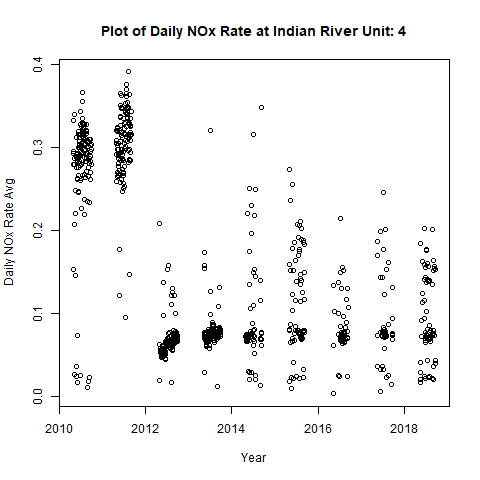

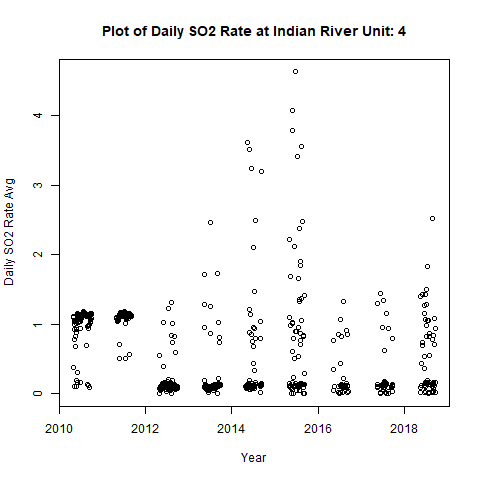

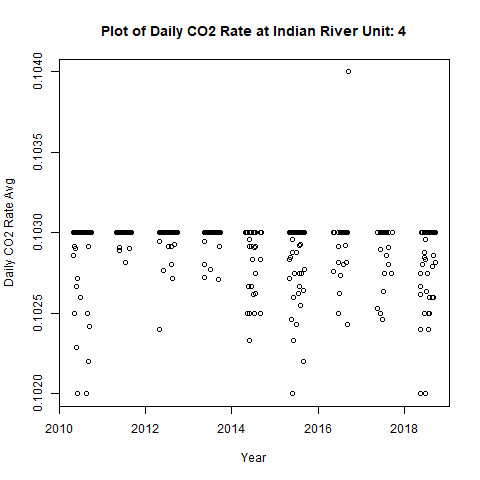

In [68]:
%R plot(facUnitDayNOxAvg$OP_DATE,facUnitDayNOxAvg$DailyNOxAvg,  xlab='Year', ylab='Daily NOx Rate Avg', main=paste('Plot of Daily NOx Rate at', siteVar, 'Unit:', unitVar, sep=" "))
%R plot(facUnitDayNOxAvg$OP_DATE,facUnitDayNOxAvg$DailySO2Avg,  xlab='Year', ylab='Daily SO2 Rate Avg', main=paste('Plot of Daily SO2 Rate at', siteVar, 'Unit:', unitVar, sep=" "))
%R plot(facUnitDayNOxAvg$OP_DATE,facUnitDayNOxAvg$DailyCO2Avg,  xlab='Year', ylab='Daily CO2 Rate Avg', main=paste('Plot of Daily CO2 Rate at', siteVar, 'Unit:', unitVar, sep=' '))

Four additional plots are created to summarize the daily NOx rate averages for the specified EGU:
- A scatter plot of the daily NOx Rate average vs the daily SO2 rate average.  If a high SO2 rate correlates with a high NOx rate, this could be an indication that the EGU is burning higher sulfur containing fuels (such as coal or distillate oil) instead of natural gas.
- A scatter plot of the daily NOx Rate average vs the daily CO2 rate average.  If a high CO2 rate correlates witha  high NOx rate, this could be an indication that the EGU is burning coal, due to higher levels of carbon than other fuels.
- A histogram of the daily NOx rate average, which helps to show the range of NOx rates at which the EGU is more frequently emitting.
- A box plot of the daily NOx rate average to help give an visual indication of the statistics related to the average daily rates.

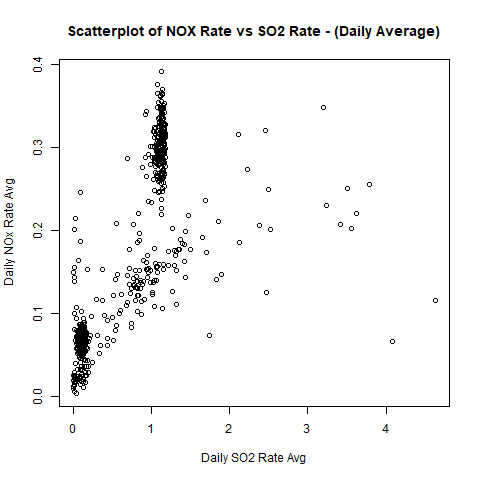

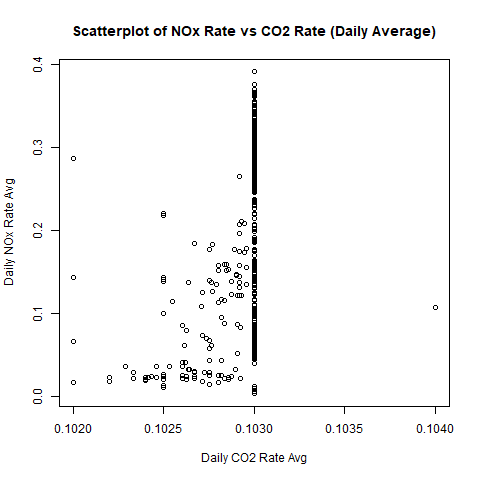

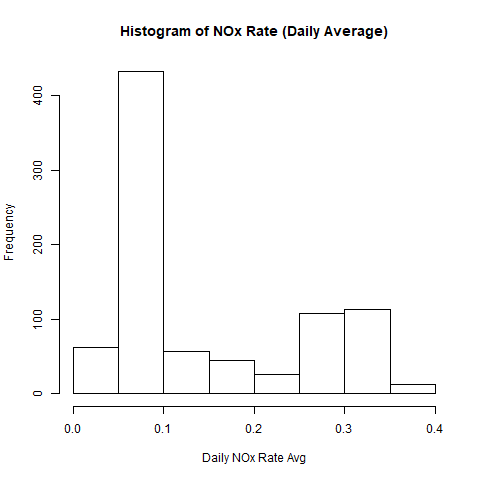

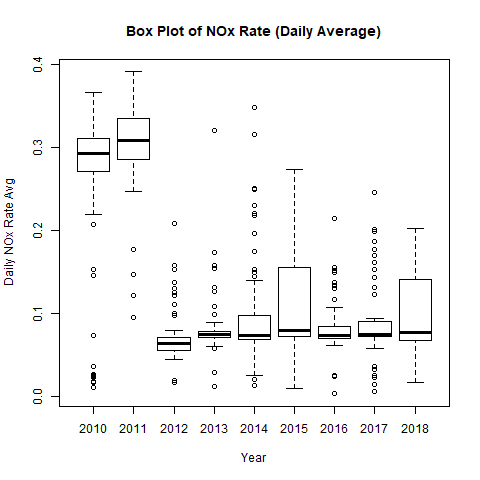

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000021833D827C8 / R:0x00000218338386D0>
[Matrix, Float..., Matrix, Float..., Float..., StrVe...]
  stats: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x0000021833D82EC8 / R:0x000002183201DA78>
[0.219625, 0.271125, 0.292396, 0.310417, ..., 0.066863, 0.076875, 0.140750, 0.202917]
  n: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000021833D82988 / R:0x00000218319EFB88>
[134.000000, 120.000000, 146.000000, 137.000000, ..., 75.000000, 57.000000, 51.000000, 68.000000]
  conf: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x0000021833D82E48 / R:0x00000218315C7968>
[0.287033, 0.297759, 0.301661, 0.316131, ..., 0.070987, 0.078929, 0.062718, 0.091032]
  out: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000021833D3F1C8 / R:0x0000021819478DF0>
[0.152333, 0.025667, 0.207500, 0.145900, ..., 0.025100, 0.161792, 0.014375, 0.130583]
  group: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000021833D35C08 / R:0x00000218303AB2E8>
[1.000000, 1.000000, 1.000000, 1.000000, ..., 8.000000, 8.000000, 8.000000, 8.000000]
  names: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000021833D86888 / R:0x0000021831BA06A8>
['2010', '2011', '2012', '2013', ..., '2015', '2016', '2017', '2018']

In [69]:
%R plot(facUnitDayNOxAvg$DailySO2Avg,facUnitDayNOxAvg$DailyNOxAvg,xlab='Daily SO2 Rate Avg',ylab='Daily NOx Rate Avg',main='Scatterplot of NOX Rate vs SO2 Rate - (Daily Average)')
%R plot(facUnitDayNOxAvg$DailyCO2Avg,facUnitDayNOxAvg$DailyNOxAvg,xlab='Daily CO2 Rate Avg',ylab='Daily NOx Rate Avg', main='Scatterplot of NOx Rate vs CO2 Rate (Daily Average)')
%R hist(facUnitDayNOxAvg$DailyNOxAvg,xlab='Daily NOx Rate Avg', main='Histogram of NOx Rate (Daily Average)')
%R boxplot(DailyNOxAvg~YEAR, data=facUnitDayNOxAvg,xlab='Year',ylab='Daily NOx Rate Avg', main='Box Plot of NOx Rate (Daily Average)')

##### Summary

Presuming the user chose to view Indian River Unit 4 in the last part of the analysis, the plots should help to "paint a picture" of its emissions profile.  Delaware has required stringent emissions controls on EGUs for approximately the last decade.  The box plots above show drastically lower daily NOx rate and SO2 rate averages since 2012, compared to 2010 and 2011.  In looking at the scatter plots for Unit 4 comparing the NOx rates with SO2 rates, it can be seen that two main clusters of points show areas of low NOx and SO2 rates, and slightly higher NOx and SO2 rates. In looking at the scatter plot comparing the NOx rates with the CO2 rates, it can be seen that the points show a "cluster" up and down the CO2 value for 0.103 ton/mmbtu CO2.  Such "high" CO2 rates compared to the NOx rates would certainly confrim the use of coal as a primary fuel, although the somewhat "arbitrary" value of 0.103 and such a "wall" beyond which there is only one data point suggests that the facility may not be correctly reporting their data (i.e, although there are no substitution flags for either SO2 or CO2, it may be possible that they are reporting a calculated value much more often than a measured value). The box plot for Unit 4 shows information similar to the box plots above, but better show the mean daily NOx rate averates over time.  

If time allows, it is suggested that this Notebook be rerun to download PA data (though only for 2015-current to minimize download and processing time), and Brunner Island Unit 1 be used as the EGU of choice in Section 4.2. EGUs in PA are not subject to the DAILY emission rate limits like EGUs are in DE.  The resulting plots in Section 4.2 will likely show more variability in NOx rates over the years, specifically with higher daily NOx rate averages through 2016, a sharp decline in 2017, and a wide range of values in 2018, which is a result of the federal "Cross State Air Pollution Rule" which began in 2017 to cap the emissions from EGUs during the ozone season from May through September.

### References:

- Devlin, J. (2017, August 3).  Using Pandas with large data.  Retrieved on December 7, 2018, from https://www.dataquest.io/blog/pandas-big-data/
- Environmental Protection Agency (n.d.).  Air Markets Program Data.  Retrieved on December 3, 2018, from https://ampd.epa.gov/ampd/
- Koenig, K. (2018, May 14). DownloadUnzipLidar.  Retrieved on November 20, 2018, from https://github.com/kristyj004/DownloadUnzipLidar/blob/master/DownloadUnzipLidar.py 
- Quinn, S., Detwiler, J., Hardisty, F., & O’Brien, J. (1999-2018). GEOG 489 - GIS Application Development, 3.11 Walkthrough: Species distribution modeling with Jupyter.  The Pennsylvania State University World Campus Certificate/MGIS Programs in GIS. Retrieved December 9, 2018, from https://www.e-education.psu.edu/geog489/home.html